In [1]:
#Based on examples from:
#   http://scikit-learn.org/stable/auto_examples/ensemble/plot_adaboost_twoclass.html
#   https://betatim.github.io/posts/sklearn-for-TMVA-users/
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns;

from sklearn import tree
from sklearn.ensemble import AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.datasets import make_gaussian_quantiles
from sklearn.metrics import roc_curve, classification_report, roc_auc_score, auc

import matplotlib.pylab as pylab
import matplotlib.pyplot as plt
params = {'legend.fontsize': 'x-large',
         'axes.labelsize': 'x-large',
         'axes.titlesize':'x-large',
         'xtick.labelsize':'x-large',
         'ytick.labelsize':'x-large'}
pylab.rcParams.update(params)

# Construct training dataset
X1, y1 = make_gaussian_quantiles(cov=2.,
                                 n_samples=2000, n_features=2,
                                 n_classes=2, random_state=1)
X2, y2 = make_gaussian_quantiles(mean=(3, 3), cov=1.5,
                                 n_samples=3000, n_features=2,
                                 n_classes=2, random_state=1)
X = np.concatenate((X1, X2))
y = np.concatenate((y1, - y2 + 1))

# Construct testing dataset
X1t, y1t = make_gaussian_quantiles(cov=2.,
                                 n_samples=2000, n_features=2,
                                 n_classes=2, random_state=2)
X2t, y2t = make_gaussian_quantiles(mean=(3, 3), cov=1.5,
                                 n_samples=3000, n_features=2,
                                 n_classes=2, random_state=2)
Xt = np.concatenate((X1t, X2t))
yt = np.concatenate((y1t, - y2t + 1))

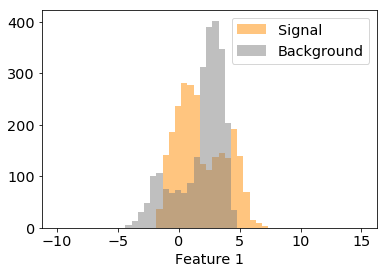

In [8]:
#Plot first feature
bins = np.linspace(-10, 15, 50)
plt.hist(X[y==0,0], bins=bins, label='Signal', alpha=0.5, color='darkorange')
plt.hist(X[y==1,0], bins=bins, label='Background', alpha=0.5, color='grey')
plt.xlabel('Feature 1')
plt.legend()
plt.show()

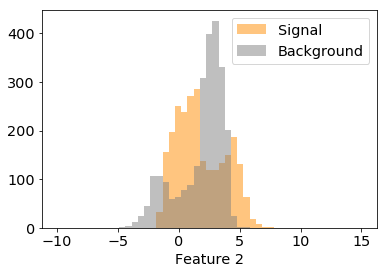

In [9]:
#Plot second feature
plt.hist(X[y==0,1], bins=bins, label='Signal', alpha=0.5, color='darkorange')
plt.hist(X[y==1,1], bins=bins, label='Background', alpha=0.5, color='grey')
plt.xlabel('Feature 2')
plt.legend()
plt.show()

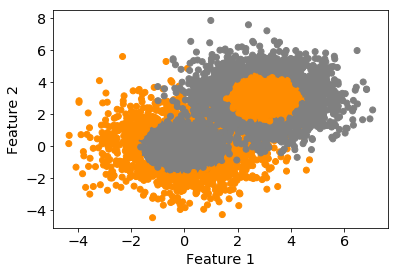

In [4]:
#Plot both features
fig, ax = plt.subplots()
cols=[('grey' if y[i]==0 else 'darkorange') for i in range(len(y))]
plt.scatter(X[:, 0], X[:, 1],  c=cols)
plt.xlabel('Feature 1')
plt.ylabel('Feature 2')
plt.show()

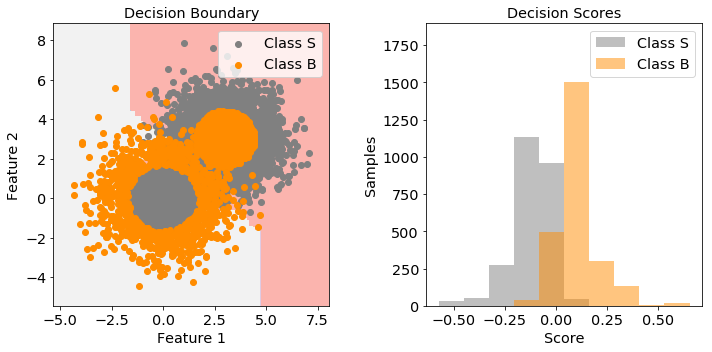

In [5]:
# Create and fit an AdaBoosted decision tree
clf=DecisionTreeClassifier(max_depth=1)
bdt = AdaBoostClassifier(clf, algorithm="SAMME", n_estimators=500)

bdt.fit(X, y)

plot_colors = ['grey', 'darkorange']
plot_step = 0.02
class_names = "SB"

plt.figure(figsize=(10, 5))

# Plot the decision boundaries
plt.subplot(121)
x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
xx, yy = np.meshgrid(np.arange(x_min, x_max, plot_step),
                     np.arange(y_min, y_max, plot_step))

Z = bdt.predict(np.c_[xx.ravel(), yy.ravel()])
Z = Z.reshape(xx.shape)
cs = plt.contourf(xx, yy, Z, cmap=plt.cm.Pastel1)
plt.axis("tight")

# Plot the training points
for i, n, c in zip(range(2), class_names, plot_colors):
    idx = np.where(y == i)
    plt.scatter(X[idx, 0], X[idx, 1],
                c=c, label="Class %s" % n)
plt.xlim(x_min, x_max)
plt.ylim(y_min, y_max)
plt.legend(loc='upper right')
plt.xlabel('Feature 1')
plt.ylabel('Feature 2')
plt.title('Decision Boundary')

# Plot the two-class decision scores
twoclass_output = bdt.decision_function(X)
plot_range = (twoclass_output.min(), twoclass_output.max())
plt.subplot(122)
for i, n, c in zip(range(2), class_names, plot_colors):
    plt.hist(twoclass_output[y == i],
             bins=10,
             range=plot_range,
             facecolor=c,
             label='Class %s' % n,
             alpha=.5)
x1, x2, y1, y2 = plt.axis()
plt.axis((x1, x2, y1, y2 * 1.2))
plt.legend(loc='upper right')
plt.ylabel('Samples')
plt.xlabel('Score')
plt.title('Decision Scores')

plt.tight_layout()
plt.subplots_adjust(wspace=0.35)
plt.show()

<b>Classification Report:</b>
<ul>
    <li>precision: ability of the classifier to not label as positive a sample that is negative (purity)
    <li>recall: ability of the classifier to find all the positive samples (efficiency)
    <li>f1-score: harmonic average of precision and recall
    <li>support: the true number of samples in this class
</ul>


In [6]:
y_predicted = bdt.predict(Xt)
print(classification_report(yt, y_predicted,
                            target_names=["Background", "Signal"]))

              precision    recall  f1-score   support

  Background       0.87      0.84      0.85      2500
      Signal       0.84      0.88      0.86      2500

   micro avg       0.86      0.86      0.86      5000
   macro avg       0.86      0.86      0.86      5000
weighted avg       0.86      0.86      0.86      5000



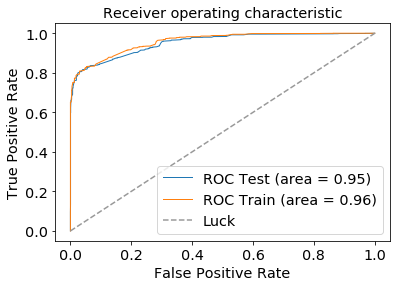

In [7]:
#Get ROC for test sample
decisions = bdt.decision_function(Xt)
fpr, tpr, thresholds = roc_curve(yt, decisions)
roc_auc = auc(fpr, tpr)

#Get ROC for training sample
decisionsb = bdt.decision_function(X)
fprb, tprb, thresholdsb = roc_curve(y, decisionsb)
roc_aucb = auc(fprb, tprb)

plt.plot(fpr, tpr, lw=1, label='ROC Test (area = %0.2f)'%(roc_auc))
plt.plot(fprb, tprb, lw=1, label='ROC Train (area = %0.2f)'%(roc_aucb))

plt.plot([0, 1], [0, 1], '--', color=(0.6, 0.6, 0.6), label='Luck')
plt.xlim([-0.05, 1.05])
plt.ylim([-0.05, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")
#plt.grid()
plt.show()